In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
%load_ext autoreload
%autoreload 2

from watermark_stable_diffusion import WatermarkStableDiffusion

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = WatermarkStableDiffusion.from_pretrained(model_id) 
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
empty_prompt_embedding = pipe.get_text_embedding("") # Assume we do not know the prompt that generated the image

In [5]:
def save_numpy_to_image(data, name):
    dpi = 100
    height, width = data.shape
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap='viridis', aspect='auto')
    plt.savefig(
        name,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0,
        transparent=True
    )
    plt.close(fig)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_86683/3027354088.py:36: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:309.)
  latents = torch.fft.ifft2(torch.fft.ifftshift(fft_latents)).type(latents.dtype)


Embedded watermark in initial latent


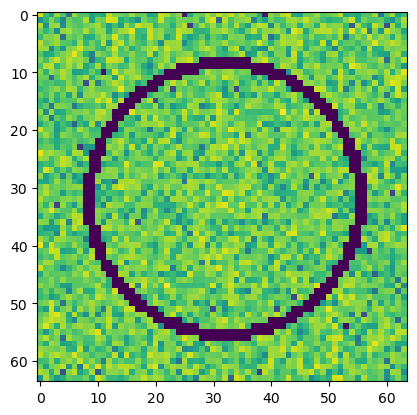

In [ ]:
prompt = "Claude Shannon holding a red balloon"

seed = 229
torch.manual_seed(seed)

from typing import Dict, Tuple

def generate_watermark_mask(latents: torch.Tensor, p = 0.7, w = 2) -> torch.Tensor:
    watermark_mask = torch.zeros_like(latents, dtype=torch.long)
    n_rows, n_cols = latents.shape[2:4]
    row_indices_c2 = (torch.arange(0, n_rows) - n_rows / 2) ** 2
    col_indices_c2 = (torch.arange(0, n_cols) - n_cols / 2) ** 2
    dist_grid = row_indices_c2.view(-1, 1) + col_indices_c2.view(1, -1) # Shape: (n_rows, n_cols)
    r = p * n_rows / 2
    watermark_mask = (dist_grid >= r ** 2) * (dist_grid <= (r + w) ** 2)
    watermark_mask = watermark_mask.repeat(latents.shape[0], latents.shape[1], 1, 1)
    return watermark_mask

target_watermark_iter = 0
num_inference_steps = 20

# Callback is called right before each denoising step
def callback_watermark(pipe: WatermarkStableDiffusion, iter: int, t: int, tensor_inputs: Dict) -> Dict:
    if iter == target_watermark_iter:
        latents = tensor_inputs['latents']
        watermark_mask = generate_watermark_mask(latents)
        fft_latents = torch.fft.fftshift(torch.fft.fft2(latents))
        min_norm = torch.min(torch.abs(fft_latents))
        fft_latents[:,0][watermark_mask[:,0]] = min_norm.type(fft_latents.dtype) # Embed only in first latent
        
        # Save noise visual
        fft_numpy = fft_latents.detach().cpu().numpy()
        data = np.log(abs(fft_numpy[0,0]))
        plt.imshow(data)
        save_numpy_to_image(latents[0,0].detach().cpu().numpy(), "initial_noise.png")
        save_numpy_to_image(data, "watermarked_noise.png")

        # Inverse fourier tranform of watermarked latents
        latents = torch.fft.ifft2(torch.fft.ifftshift(fft_latents)).type(latents.dtype)

        print("Embedded watermark in initial latent")
        return {"latents" : latents}
    return {}
    
image = pipe(prompt,
            output_type='pil', 
            num_inference_steps=num_inference_steps,
            callback_on_step_end=callback_watermark, # type: ignore
            callback_on_step_end_tensor_inputs=['latents']).images[0] # type:ignore

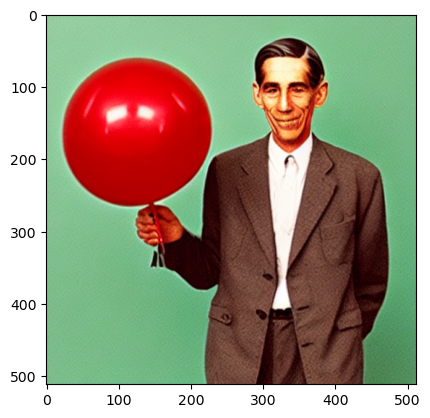

In [7]:
img_array = np.array(image)

plt.imshow(img_array)
plt.show()

In [8]:
def transform_image(image, target_size=512):
    """resize and output -1..1"""
    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0

image_tensor = transform_image(image).unsqueeze(0).cuda()
image_gen_latents = pipe.get_image_latents(image=image_tensor, sample=False)

In [9]:
tester_prompt = ''
text_embeddings = pipe.get_text_embedding(tester_prompt)

# Reverse the noise conditioned on an EMPTY prompt

image_noise = pipe(latents=image_gen_latents,
            prompt_embeds=text_embeddings,
            output_type='pil', 
            guidance_scale=1,
            num_inference_steps=50,
            forward_process=True).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

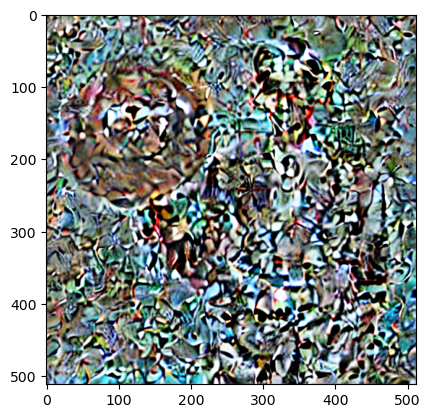

In [10]:
plt.imshow(image_noise)
plt.show()

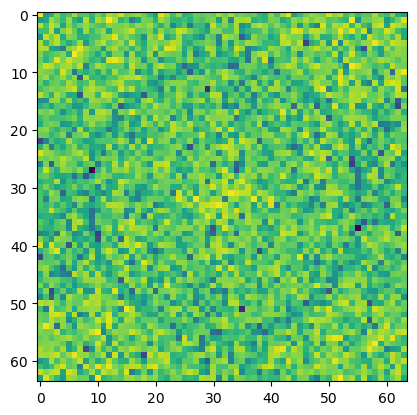

In [11]:
noise_latents = pipe.get_last_latent()
fft_latents = torch.fft.fftshift(torch.fft.fft2(noise_latents))
fft_numpy = fft_latents.detach().cpu().numpy()
data = np.log(abs(fft_numpy[0,0]))
plt.imshow(data)
save_numpy_to_image(data, "reverse_watermarked_noise.png")


In [12]:
noise_latents = pipe.get_last_latent()

image_noise_rev = pipe(prompt,
            latents=noise_latents,
            output_type='pil', 
            guidance_scale=1,
            num_inference_steps=20).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

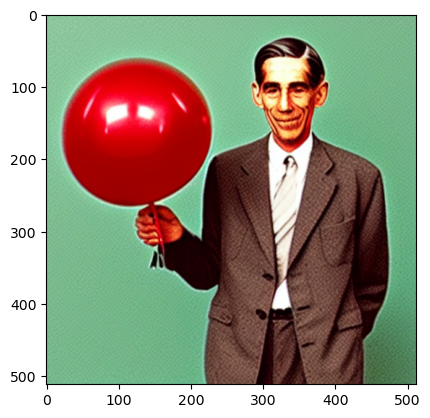

In [13]:
plt.imshow(image_noise_rev)
plt.show()

In [14]:
seed = 229
torch.manual_seed(seed)

image_clean = pipe(prompt,
            output_type='pil', 
            num_inference_steps=20).images[0] # type:ignore

  0%|          | 0/20 [00:00<?, ?it/s]

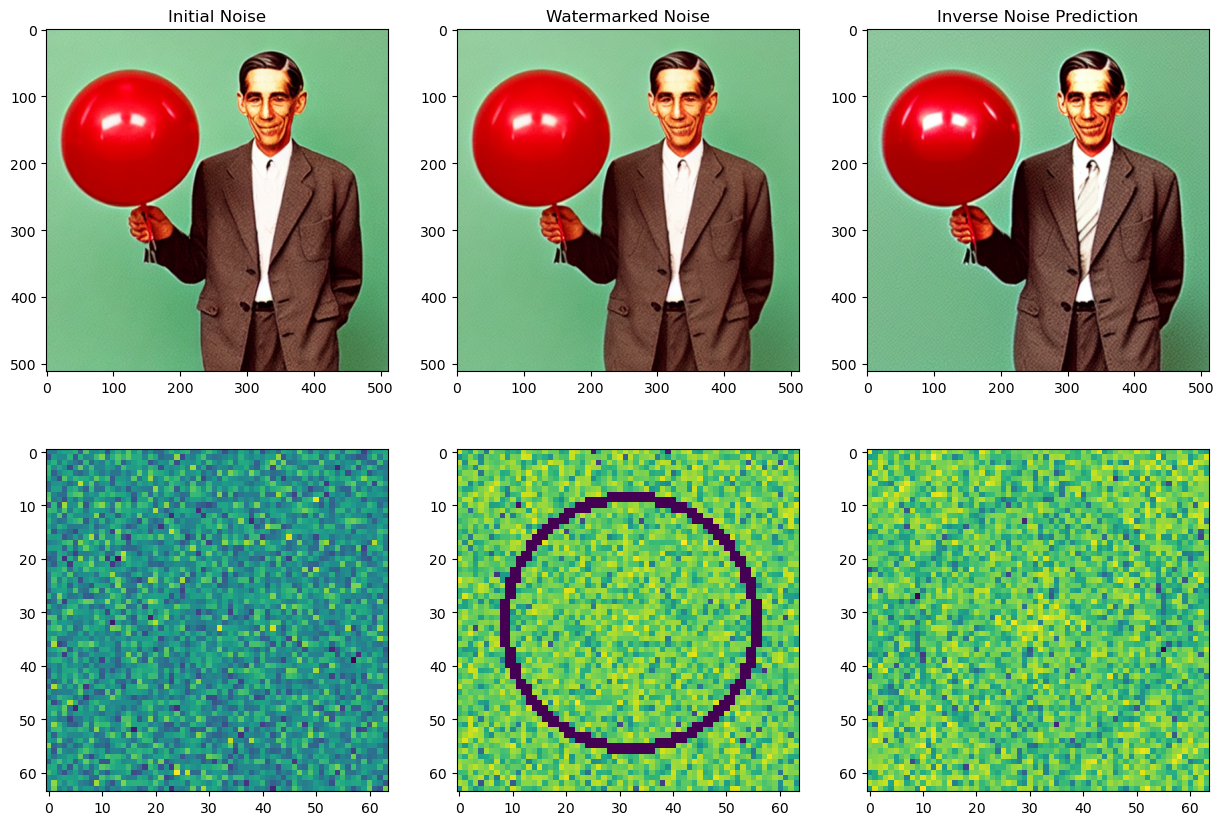

In [15]:
from PIL import Image

initial_noise = np.asarray(Image.open("initial_noise.png"))
watermarked_noise = np.asarray(Image.open("watermarked_noise.png"))
reverse_watermarked_noise = np.asarray(Image.open("reverse_watermarked_noise.png"))

fig, ax = plt.subplots(2,3,figsize=(15, 10))

ax[0, 0].imshow(image_clean)
ax[0, 0].set_title("Initial Noise")
ax[0, 1].imshow(img_array)
ax[0, 1].set_title("Watermarked Noise")
ax[0, 2].imshow(image_noise_rev)
ax[0, 2].set_title("Inverse Noise Prediction")

ax[1, 0].imshow(initial_noise)
ax[1, 1].imshow(watermarked_noise)
ax[1, 2].imshow(reverse_watermarked_noise)

plt.show()